In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder {folder_path} created successfully.")
    else:
        print(f"Folder {folder_path} already exists.")
create_folder_if_not_exists("plots")
create_folder_if_not_exists("errors")

Folder plots already exists.
Folder errors already exists.


**Równomierna dystrybucja**

In [4]:
def even_domain(x_min, x_max, number_of_points):
    return np.linspace(x_min, x_max, number_of_points, dtype=np.double)

**Zera wielomianu Czebyszewa**

In [5]:
def get_chebyshev_zeros(x_min=None, x_max=None, number_of_points=None):
    if x_min is None and x_max is not None or x_min is not None and x_max is None:
        raise ValueError("x_min and x_max must be both None or both not None")
    chebyshev_zeroes = np.array(0, dtype=np.double)
    for k in range(number_of_points):
        cur_zero = np.cos((2 * k + 1) * np.pi / (2 * number_of_points))
        if x_min is not None and x_max is not None:
            cur_zero = (x_max - x_min) / 2 * cur_zero + (x_max + x_min) / 2
        chebyshev_zeroes = np.append(chebyshev_zeroes, cur_zero)
    return chebyshev_zeroes[1:]

**Interpolacja Hermite'a**

In [6]:
def factorial(x):
    if x == 0:
        return 1
    result = 1
    for i in range(1, x + 1):
        result *= i
    return result

def hermite_interpolation(function, x, x_zeroes, x_weights):
    n = 0
    for i in range(len(x_weights)):
        n += x_weights[i]
    if len(x_zeroes) != len(x_weights):
        raise ValueError("x_zeroes and x_weights must have the same length")

    def get_difference_quotient_table():
        nonlocal function
        nonlocal x_zeroes
        nonlocal n
        nonlocal x_weights
        derivatives = [first_derivative]

        idx_to_x_zero = []
        for i in range(len(x_weights)):
            for _ in range(x_weights[i]):
                idx_to_x_zero.append((i, x_zeroes[i]))

        table = np.full((n, n), np.inf ,dtype=np.double)
        for i in range(n):
            table[i][0] = function(idx_to_x_zero[i][1])
        for i in range(1, n):
            for j in range(1, i+1):
                i_idx, i_value = idx_to_x_zero[i]
                j_idx, j_value = idx_to_x_zero[i-j]
                if i_idx == j_idx and j < x_weights[i_idx]:
                    if j - 1 >= len(derivatives):
                        raise ValueError("j - 1 >= len(derivatives)")
                    table[i][j] = derivatives[j - 1](i_value) / factorial(j)
                else:
                    table[i][j] = (table[i][j-1] - table[i - 1][j - 1]) / (i_value - j_value)
        return table

    def p(i_):
        nonlocal  x_weights
        nonlocal x_zeroes
        nonlocal x
        p = 1
        if i_ == 0:
            return p
        active_x = counter = 0
        while counter < i_:
            for _ in range(x_weights[active_x]):
                if counter >= i_:
                    break
                p = p * (x - x_zeroes[active_x])
                counter += 1
            active_x += 1
        return p

    difference_quotient_table = get_difference_quotient_table()
    Pn = 0
    for l in range(n):
        Pn += difference_quotient_table[l][l] * p(l)
    return Pn

def interpolate_hermite(function, domain, x_zeroes, x_weights):
    result = []
    for i in range(len(domain)):
        result.append(hermite_interpolation(function=function, x=domain[i], x_zeroes=x_zeroes, x_weights=x_weights))
    return result

**Wizualizacja**

In [7]:
def visualise(domain=None, nodes_x=None, nodes_y=None, f_y=None, Pn_x=None, mode=None, x_size=8, y_size=6,
              filename=None):
    '''
    :param domain: array of float64, of x coordinates of points to visualise
    :param nodes_x: array of x coordinates of nodes
    :param nodes_y: array of f(x) for each x in nodes_x
    :param f_y: array of f(x) for each x in domain
    :param Pn_x: array of Pn(x) for each x in domain
    :param mode: "lagrange" or "newton" or "impo"
    :param x_size: size of a figure in x axis
    :param y_size: size of a figure in y axis
    :param filename: name of a file to save a figure
    :return: None
    '''
    plt.figure(figsize=(x_size, y_size))
    if nodes_x is not None and nodes_y is not None:
        plt.scatter(nodes_x, nodes_y, label="Węzły", color="green")
    if f_y is not None:
        plt.plot(domain, f_y, label="Zadana funckcja", color="blue")

    if mode == "lagrange":
        plt.plot(domain, Pn_x, label="Interpolacja Lagrange'a", color="red")
    elif mode == "newton":
        plt.plot(domain, Pn_x, label="Interpolacja Newtona", color="red")
    elif mode == "hermite":
        plt.plot(domain, Pn_x, label="Interpolacja Hermite'a", color="red")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    if filename is not None:
        plt.savefig(f"plots/{filename}.png", dpi=300, format='png')
    plt.show()

**Implementacja funkcji do laboratorium**

In [8]:
pi = np.double(np.pi)
interval_start = -2 * pi
interval_end = pi
base_domain = np.arange(interval_start, interval_end, 0.01)


def function_given(x):
    m = 2
    k = 2
    global pi
    return np.sin(m * x) * np.sin(k * (x * x) / pi)


def first_derivative(x):
    m = 2
    k = 2
    global pi
    return 2 * k * x * np.cos(k * x ** 2 / pi)  * np.sin(m * x)/ pi + m * np.sin(k * x ** 2 / pi) * np.cos(m * x)

def get_weights(n):
    return [2 for _ in range(n)]

function_given_values = []
for random_name in range(len(base_domain)):
    function_given_values.append(function_given(base_domain[random_name]))


def get_function_values(X):
    result = np.zeros(len(X), dtype=np.double)
    for i in range(len(X)):
        result[i] = function_given(X[i])
    return result


def get_abs_error(f1, f2):
    max_error = -1
    if len(f1) != len(f2):
        raise Exception("f1 and f2 must have the same length")
    for i in range(len(f1)):
        max_error = max(max_error, abs(f1[i] - f2[i]))
    return max_error


def get_square_mean_error(f1, f2):
    error_sum = 0
    if len(f1) != len(f2):
        raise Exception("f1 and f2 must have the same length")
    for i in range(len(f1)):
        error_sum += (f1[i] - f2[i]) ** 2
    return np.sqrt(error_sum) / len(f1)

def visualise_hermite(number_of_nodes, domain, function, nodes_distribution_mode="even", filename=None):
    nodes_x = None
    if nodes_distribution_mode == "even":
        nodes_x = even_domain(x_min=interval_start, x_max=interval_end, number_of_points=number_of_nodes)
    elif nodes_distribution_mode == "chebyshev":
        nodes_x = get_chebyshev_zeros(x_min=interval_start, x_max=interval_end, number_of_points=number_of_nodes)
    nodes_y = []
    for i in range(len(nodes_x)):
        nodes_y.append(function(nodes_x[i]))
    own_lagrange_values = interpolate_hermite(function=function,
                                              domain=domain,
                                              x_zeroes=nodes_x,
                                              x_weights=get_weights(len(nodes_x)))
    visualise(domain=base_domain, nodes_x=nodes_x, nodes_y=nodes_y, f_y=function_given_values, Pn_x=own_lagrange_values,
              mode="hermite", filename=filename)

**Wykonanie ćwiczenia**

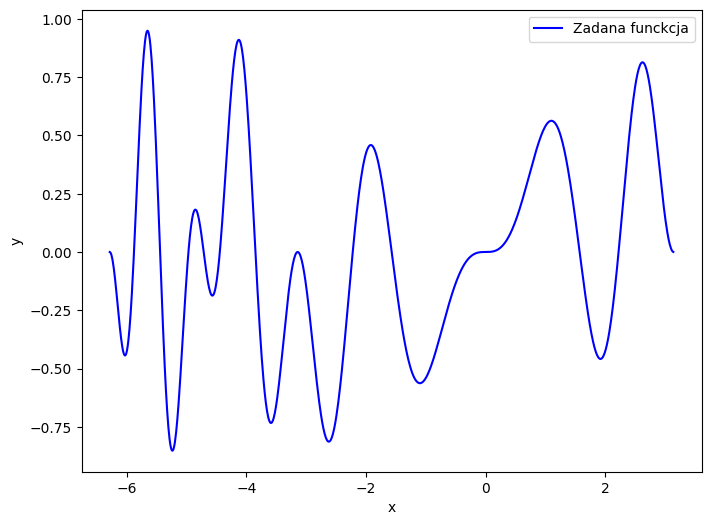

In [9]:
visualise(base_domain, None, None, function_given_values)

Liczba węzłów:  3
Wizualizacja Hermite'a, węzły równoodległe


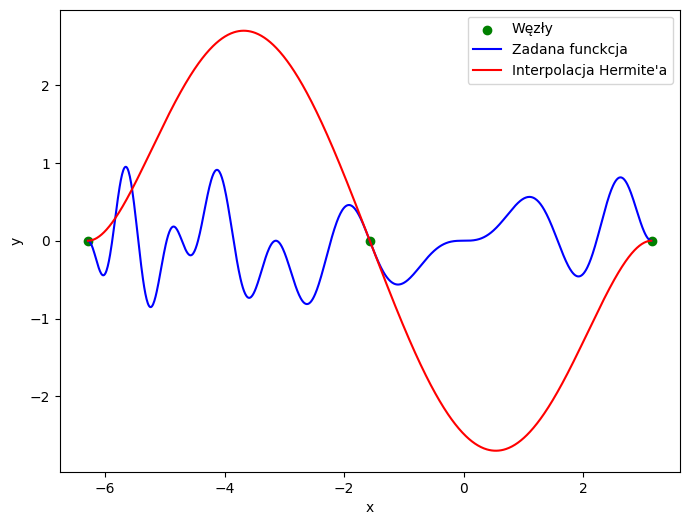

Wizualizacja Hermite'a, węzły Czebyszewa


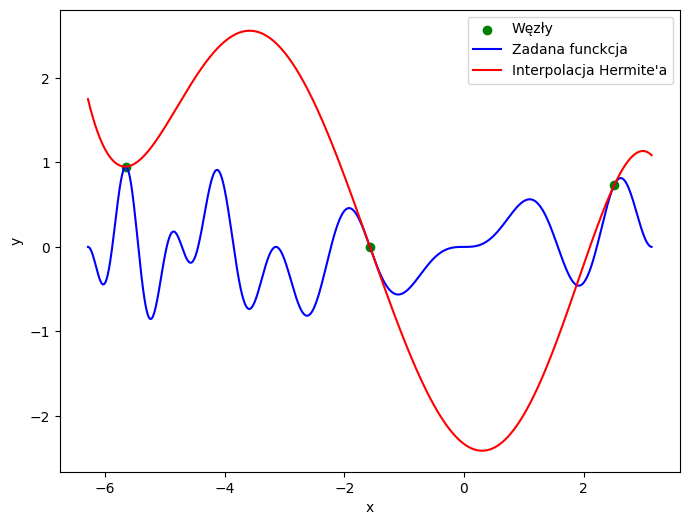

Liczba węzłów:  4
Wizualizacja Hermite'a, węzły równoodległe


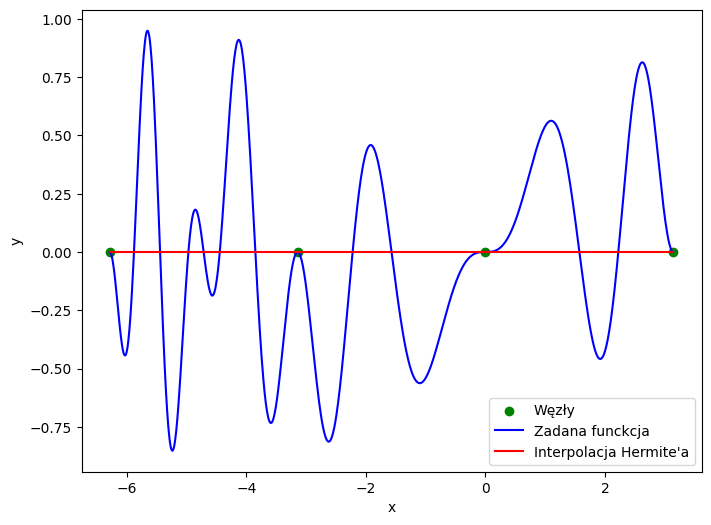

Wizualizacja Hermite'a, węzły Czebyszewa


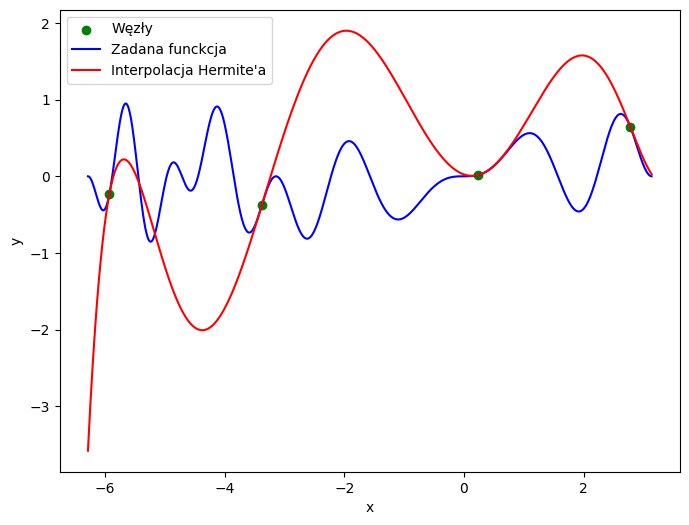

Liczba węzłów:  5
Wizualizacja Hermite'a, węzły równoodległe


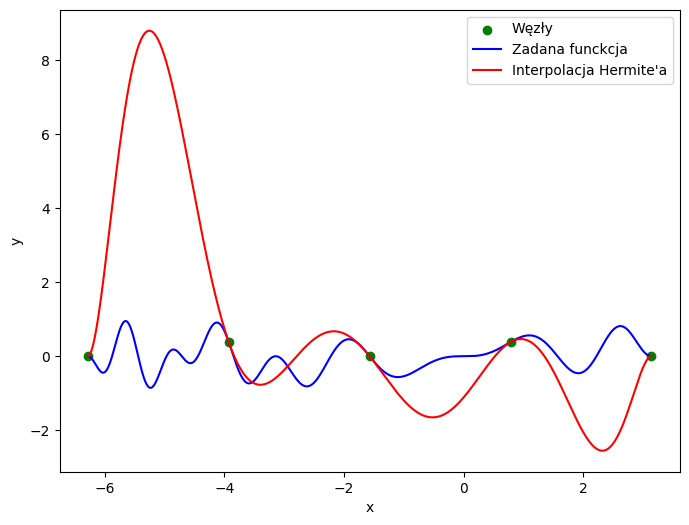

Wizualizacja Hermite'a, węzły Czebyszewa


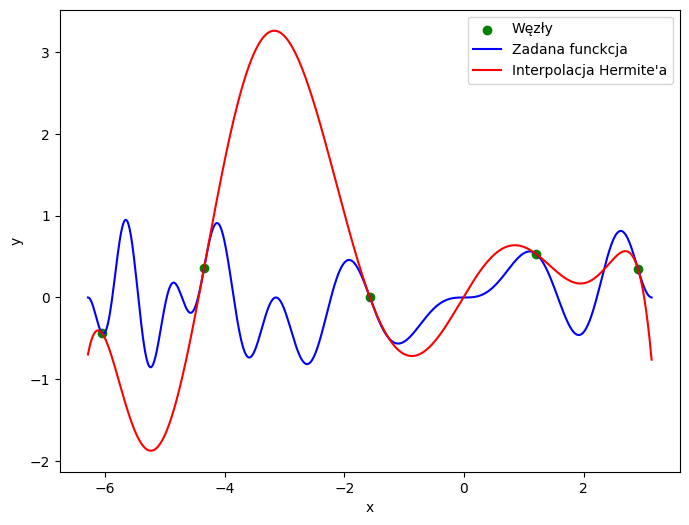

Liczba węzłów:  7
Wizualizacja Hermite'a, węzły równoodległe


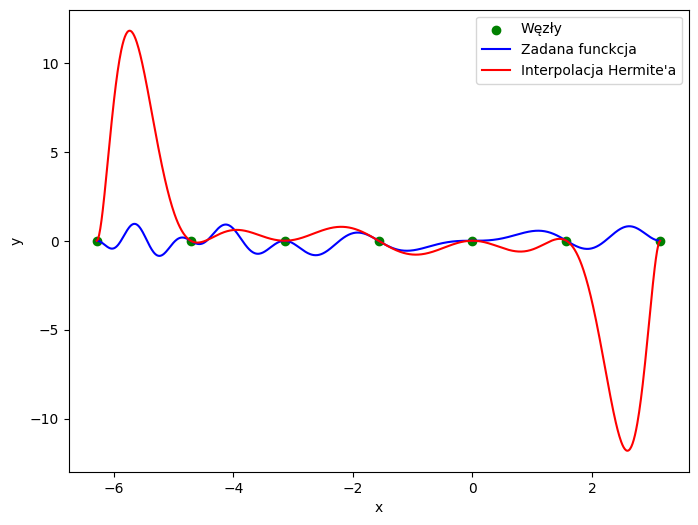

Wizualizacja Hermite'a, węzły Czebyszewa


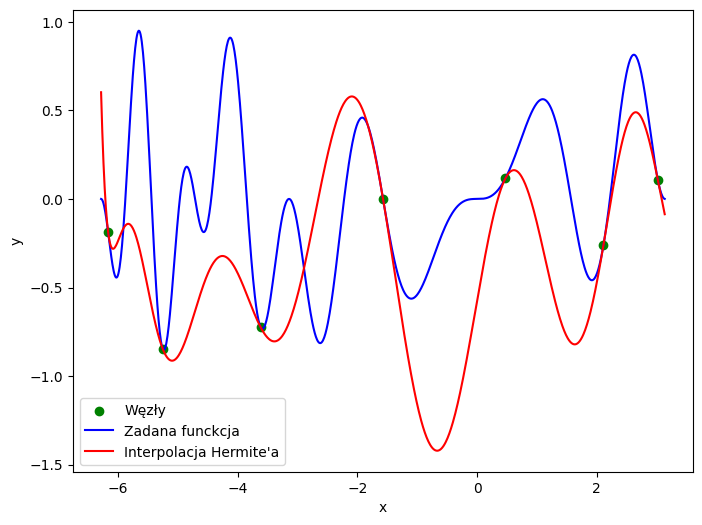

Liczba węzłów:  10
Wizualizacja Hermite'a, węzły równoodległe


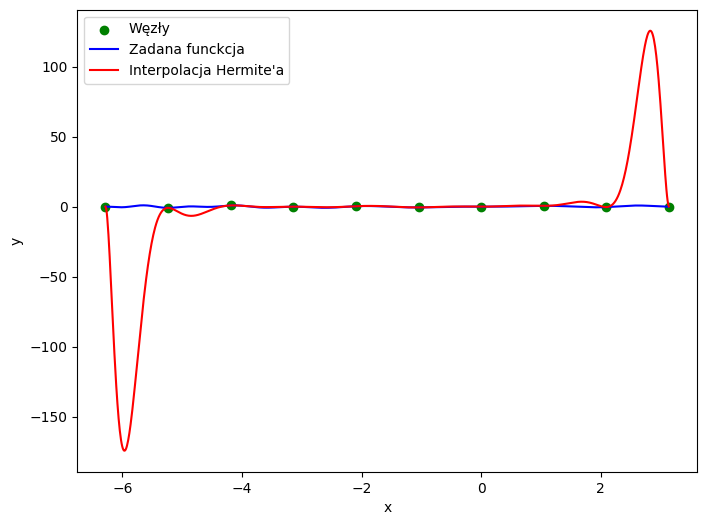

Wizualizacja Hermite'a, węzły Czebyszewa


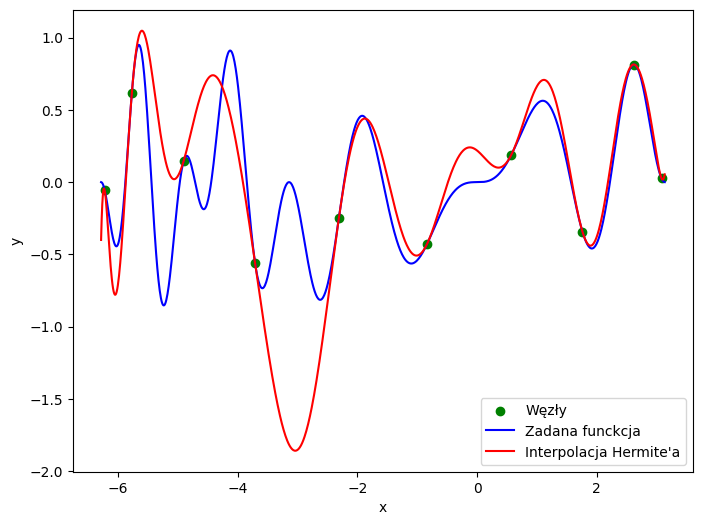

Liczba węzłów:  15
Wizualizacja Hermite'a, węzły równoodległe


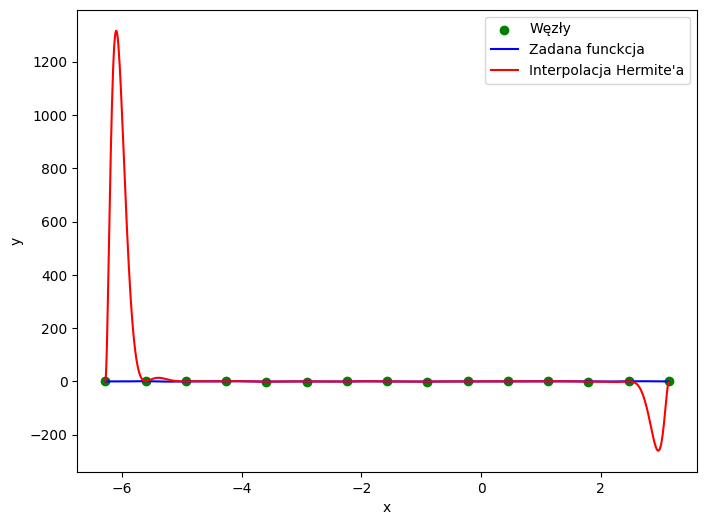

Wizualizacja Hermite'a, węzły Czebyszewa


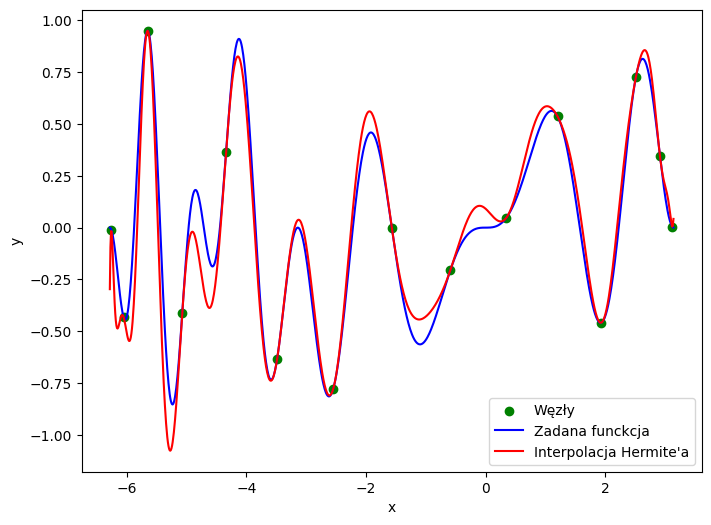

Liczba węzłów:  20
Wizualizacja Hermite'a, węzły równoodległe


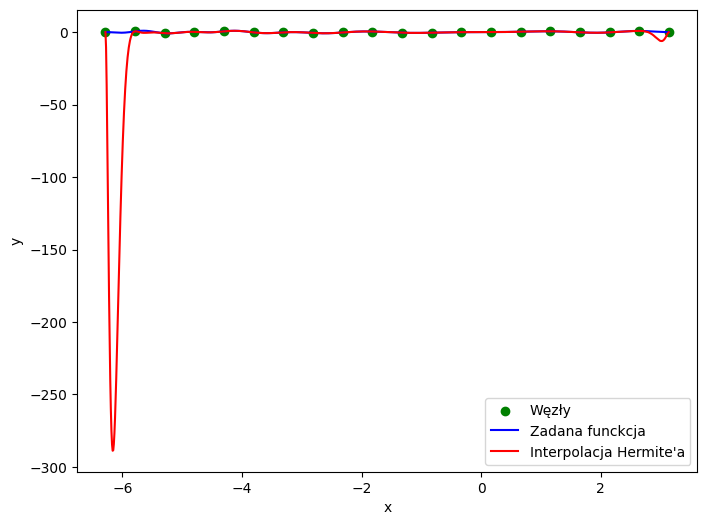

Wizualizacja Hermite'a, węzły Czebyszewa


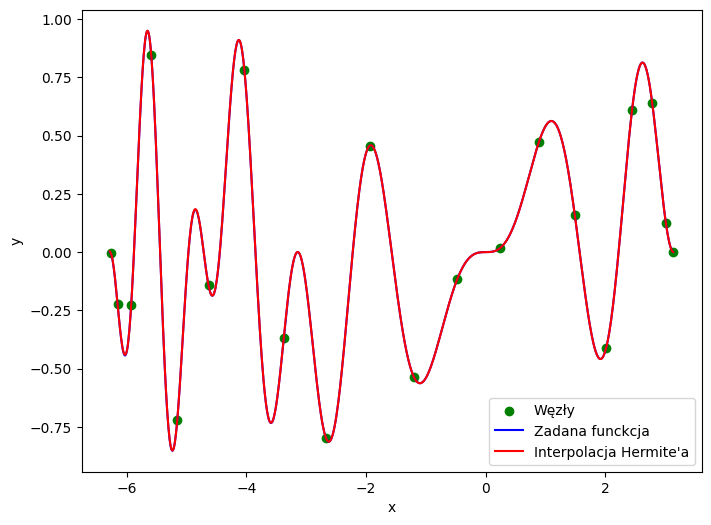

Liczba węzłów:  25
Wizualizacja Hermite'a, węzły równoodległe


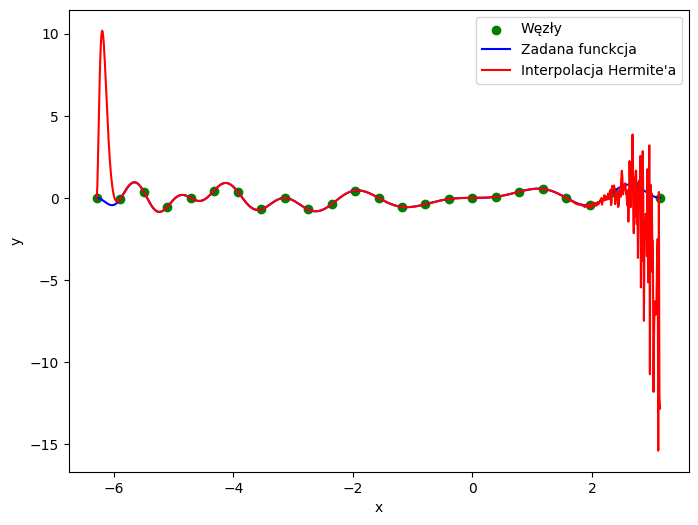

Wizualizacja Hermite'a, węzły Czebyszewa


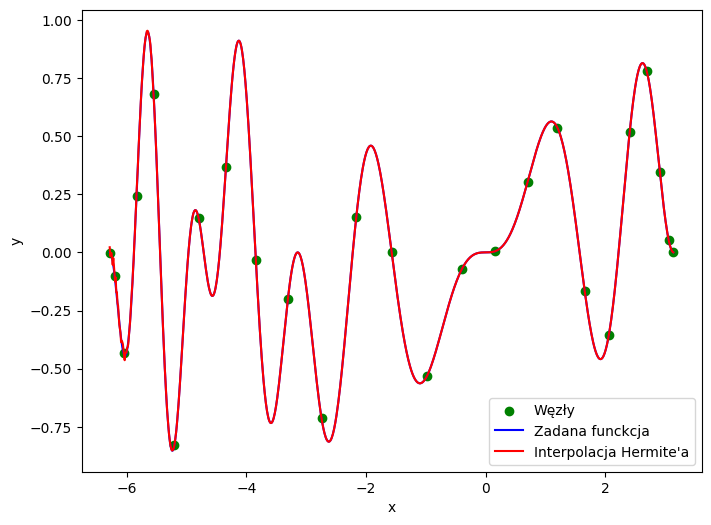

Liczba węzłów:  50
Wizualizacja Hermite'a, węzły równoodległe


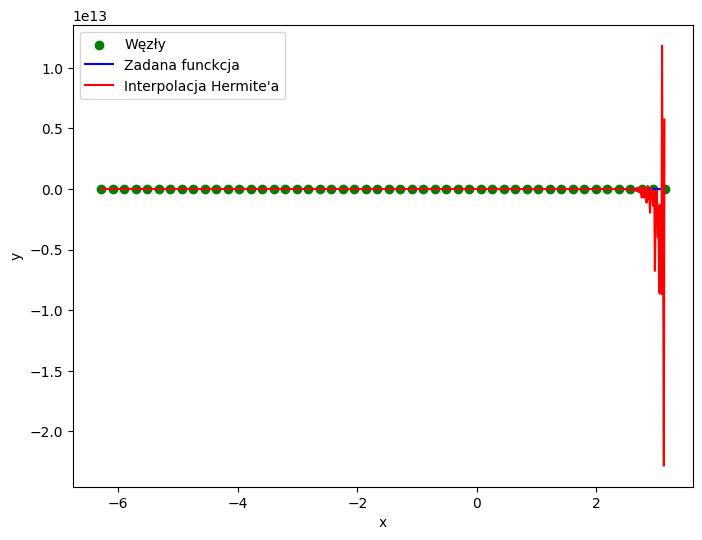

Wizualizacja Hermite'a, węzły Czebyszewa


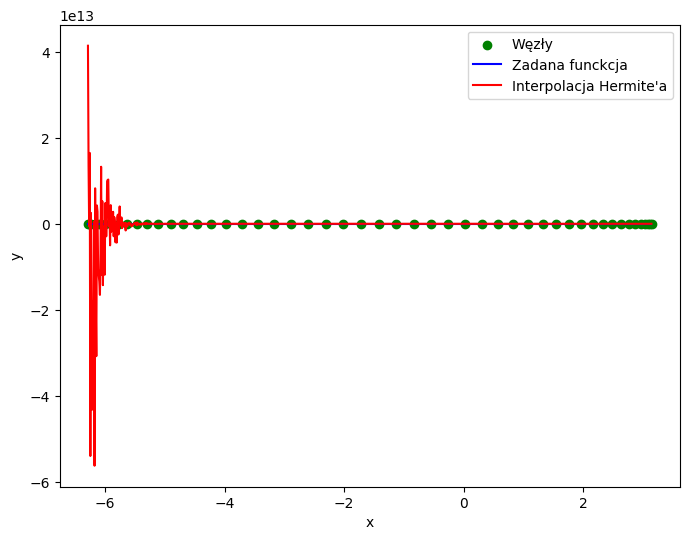

In [10]:
given_number_of_nodes = [3, 4, 5, 7, 10, 15, 20, 25, 50]


def get_all_visualisations(number):
    print("Liczba węzłów: ", number)
    even_nodes = even_domain(x_min=interval_start, x_max=interval_end, number_of_points=number)
    chebyshev_nodes = get_chebyshev_zeros(x_min=interval_start, x_max=interval_end, number_of_points=number)
    print("Wizualizacja Hermite'a, węzły równoodległe")
    visualise_hermite(number_of_nodes=number,
                      domain=base_domain,
                      function=function_given,
                      nodes_distribution_mode="even",
                      filename=f"hermite_{number}_even")
    print("Wizualizacja Hermite'a, węzły Czebyszewa")
    visualise_hermite(number_of_nodes=number,
                      domain=base_domain,
                      function=function_given,
                      nodes_distribution_mode="chebyshev",
                      filename=f"hermite_{number}_chebyshev")


for cur_number in given_number_of_nodes:
    get_all_visualisations(cur_number)

In [11]:
import csv


def save_to_csv(filename, data):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data)

In [12]:
def hermite_results_errors():
    global given_number_of_nodes
    csv_header = ["Liczba węzłów", "Równoodległe, błąd maksymalny, ", "Równoodległe, błąd kwadratowy",
                  "Czebyszew, błąd maksymalny", "Czebyszew, błąd kwadratowy"]
    csv_file = [csv_header]
    for number_of_nodes in given_number_of_nodes:
        csv_record = [number_of_nodes]
        even_nodes = even_domain(x_min=interval_start, x_max=interval_end, number_of_points=number_of_nodes)
        chebyshev_nodes = get_chebyshev_zeros(x_min=interval_start, x_max=interval_end,
                                              number_of_points=number_of_nodes)
        exact_result = []
        for i in range(len(base_domain)):
            exact_result.append(function_given(base_domain[i]))

        hermite_even_result = interpolate_hermite(function=function_given,
                                                  domain=base_domain,
                                                  x_zeroes=even_nodes,
                                                  x_weights=get_weights(len(even_nodes)))
        hermite_even_abs_error = get_abs_error(exact_result, hermite_even_result)
        csv_record.append(hermite_even_abs_error)
        hermite_even_sqrt_error = get_square_mean_error(exact_result, hermite_even_result)
        csv_record.append(hermite_even_sqrt_error)

        hermite_chebyshev_result = interpolate_hermite(function=function_given,
                                                       domain=base_domain,
                                                       x_zeroes=chebyshev_nodes,
                                                       x_weights=get_weights(len(chebyshev_nodes)))
        hermite_chebyshev_abs_error = get_abs_error(exact_result, hermite_chebyshev_result)
        csv_record.append(hermite_chebyshev_abs_error)
        hermite_chebyshev_sqrt_error = get_square_mean_error(exact_result, hermite_chebyshev_result)
        csv_record.append(hermite_chebyshev_sqrt_error)
        csv_file.append(csv_record)

    save_to_csv("errors/hermite_errors.csv", csv_file)


hermite_results_errors()